In [ ]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install accelerate --quiet

In [ ]:
from datasets import list_datasets, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

## Loading Data

In [ ]:
emotions = load_dataset('emotion', trust_remote_code=True)

emotions

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_data = emotions['train']
test_data = emotions['test']
val_data = emotions['validation']

In [ ]:
train_data.column_names

['text', 'label']

In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
train_data['text'][0:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [ ]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


## EDA

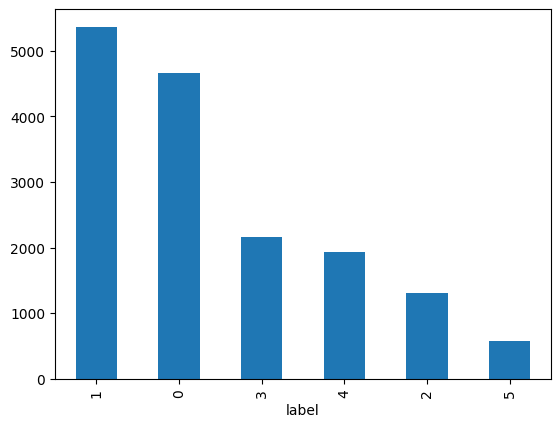

In [ ]:
df['label'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
df['Label Name'] = df['label'].map({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})
df.head()

,text,label,Label Name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


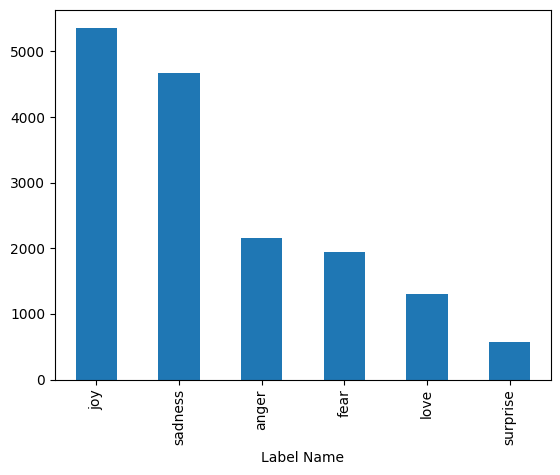

In [ ]:
df['Label Name'].value_counts().plot(kind = 'bar')
plt.show()

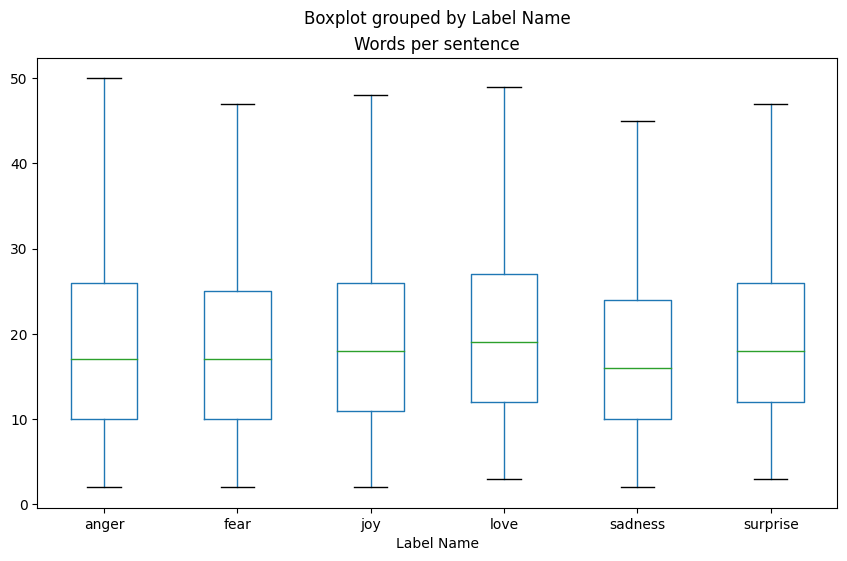

In [ ]:
## Maximum words per sentence since some models have a limit on the number of input tokens

df["Words per sentence"] = df['text'].apply(lambda x: len(str.split(x)))

df.boxplot('Words per sentence', by='Label Name', figsize=(10, 6), showfliers=False,grid=False)
plt.title('Words per sentence')
plt.show()

## Encoding the words

In [ ]:
emotions.reset_format()

In [ ]:
from transformers import AutoTokenizer

model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenize(emotions['train'][:1])['input_ids'][0])
print(tokens)

['[CLS]', 'i', 'didn', '##t', 'feel', 'humiliated', '[SEP]']


### Encoding Dataset

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


## Model

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(model)

model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
# prompt: torch cuda check

print(torch.cuda.is_available())


True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

## Fine Tuning

In [ ]:
df['Label Name'].nunique()

6

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model_name = 'distilbert-base-uncased'

model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Performance Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

### Training

In [52]:
from transformers import Trainer, TrainingArguments

batch = 16
logging_steps = len(emotions['train']) // batch

final_model = f"{model_name}-finetuned-emotion"

training = TrainingArguments(output_dir='/content/Emotion-Detector',
                             num_train_epochs=5,
                             per_device_train_batch_size=batch,
                             per_device_eval_batch_size=batch,
                             logging_steps=logging_steps,
                             evaluation_strategy='epoch',
                             log_level='error',
                             disable_tqdm=False)

trainer = Trainer(model=model, args=training,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'], tokenizer=tokenizer)

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.377700,0.192935,0.931000,0.932030


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.377700,0.192935,0.931000,0.932030
2,0.139000,0.169798,0.937500,0.936546
3,0.099800,0.163486,0.942000,0.942212
4,0.073700,0.221633,0.941500,0.941555
5,0.039000,0.255935,0.941500,0.941274


events.out.tfevents.1719664752.0d17eb352516.703.2:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Foulbubble/Emotion-Detector/commit/810f85959f7ec0a40a4fd20854ab17e320dc3490', commit_message='Training completed!', commit_description='', oid='810f85959f7ec0a40a4fd20854ab17e320dc3490', pr_url=None, pr_revision=None, pr_num=None)

### Evaluation

In [ ]:
pred_output = trainer.predict(emotions_encoded['test'])
pred_output.metrics

{'test_loss': 0.3578910529613495,
 'test_accuracy': 0.925,
 'test_f1': 0.9247173380311278,
 'test_runtime': 4.1615,
 'test_samples_per_second': 480.596,
 'test_steps_per_second': 30.037}

In [ ]:
y_preds = np.argmax(pred_output.predictions, axis=1)
y_true = emotions_encoded['test']['label']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
labels = ['sadness' ,'joy', 'love' ,'anger' ,'fear', 'surprise']
print(labels)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       581
           1       0.94      0.95      0.95       695
           2       0.82      0.81      0.82       159
           3       0.93      0.91      0.92       275
           4       0.88      0.91      0.89       224
           5       0.77      0.71      0.74        66

    accuracy                           0.93      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.93      0.92      2000



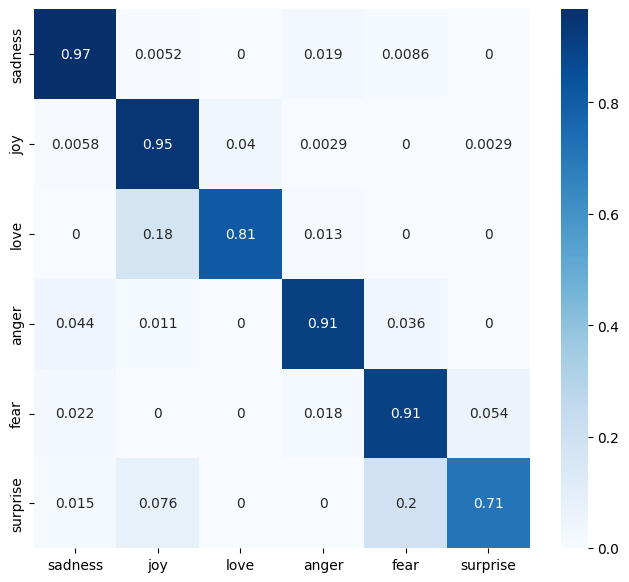

In [ ]:
plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_true, y_preds, normalize="true"), cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
plt.show()

In [ ]:
cols = ["text", "label", "predicted", "loss"]

emotions_encoded.set_format("pandas")

df_test = emotions_encoded['test'][:][['text', 'label']]

In [ ]:
df_test.shape

(2000, 2)

## Prediction

In [ ]:
df_test['prediction'] = y_preds
df_test

,text,label,prediction
0,im feeling rather rotten so im not very ambiti...,0,0
1,im updating my blog because i feel shitty,0,0
2,i never make her separate from me because i do...,0,0
3,i left with my bouquet of red and yellow tulip...,1,1
4,i was feeling a little vain when i did this one,0,0
...,...,...,...
1995,i just keep feeling like someone is being unki...,3,3
1996,im feeling a little cranky negative after this...,3,3
1997,i feel that i am useful to my people and that ...,1,1
1998,im feeling more comfortable with derby i feel ...,1,1


In [ ]:
df_test['label'] = df_test['label'].map({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})
df_test['prediction'] = df_test['prediction'].map({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})

In [ ]:
df_test

,text,label,prediction
0,im feeling rather rotten so im not very ambiti...,sadness,sadness
1,im updating my blog because i feel shitty,sadness,sadness
2,i never make her separate from me because i do...,sadness,sadness
3,i left with my bouquet of red and yellow tulip...,joy,joy
4,i was feeling a little vain when i did this one,sadness,sadness
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,anger
1996,im feeling a little cranky negative after this...,anger,anger
1997,i feel that i am useful to my people and that ...,joy,joy
1998,im feeling more comfortable with derby i feel ...,joy,joy


In [ ]:
text = "i love doing nlp projects"
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  output = model(**input_encoded)
  pred_label = torch.argmax(output.logits, axis=1).item()
  print(labels[pred_label])

joy


In [ ]:
id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
label2id = {v: k for k, v in id2label.items()}
model_name = "Emotion-Detector-Model"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
).to(device)

In [ ]:
text = "i love doing nlp projects"
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(**input_encoded)
    pred_label_id = torch.argmax(output.logits, axis=1).item()
    pred_label = model.config.id2label[pred_label_id]
    print(pred_label)

joy
